# **BERT Model Implementation**

In [1]:
# Required packages

!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U seaborn
!pip install -U evaluate
!pip install -U emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 101.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   

# Data Preprocessing

In [2]:
import pandas as pd
import re

def load_dataset(file_path, label):
    """
    Load the dataset from a file and add a numeric label to each entry.

    Args:
    - file_path (str): Path to the dataset file containing text data. Each line in the file
      should represent one entry (e.g., a tweet or text sample).
    - label (int): Numeric label to associate with all entries in the dataset. Typically,
      1 for positive sentiment and 0 for negative sentiment.

    Returns:
    - pd.DataFrame: A Pandas DataFrame with the following columns:
        - 'text': The textual data loaded from the file.
        - 'label': The numeric label provided, applied to all entries in the dataset.
    """
    # Open the file at the given path with UTF-8 encoding and read all lines into a list.
    with open(file_path, 'r', encoding='utf-8') as file:
        tweets = file.readlines()

    # Create a DataFrame from the list of tweets with a single column named 'text'.
    df = pd.DataFrame(tweets, columns=['text'])

    # Add a new column 'label' to the DataFrame and assign the provided label value to all rows.
    df['label'] = label

    # Return the resulting DataFrame.
    return df

def clean_tweet(tweet):
    """
    Clean a single tweet by removing unnecessary parts such as placeholders, special characters,
    and normalizing text.

    Args:
    - tweet (str): The raw tweet text.

    Returns:
    - str: The cleaned tweet text.
    """
    tweet = re.sub(r"<user>", "", tweet)  # Remove <user>
    tweet = re.sub(r"<url>", "", tweet)  # Remove <url>
    tweet = re.sub(r"#", "", tweet)  # Remove hashtags
    tweet = re.sub(r"<3", "heart", tweet)  # Replace "<3" with "heart"
    tweet = re.sub(r"\brt\b", "", tweet)  # Remove the "rt" token (retweet indicator)
    tweet = re.sub(r"\.{2,}", "", tweet)  # Remove ellipses (two or more dots)
    tweet = re.sub(r"\s+", " ", tweet)  # Normalize whitespace
    tweet = re.sub(r"\b\d+(?:st|nd|rd|th)?\b", "", tweet)  # Remove numbers and ordinals
    return tweet.strip()

# Paths to your datasets
# Specify file paths for negative and positive sentiment training data.
train_neg_path = 'drive/MyDrive/Colab Notebooks/train_neg_full.txt'  # Path to negative tweets dataset
train_pos_path = 'drive/MyDrive/Colab Notebooks/train_pos_full.txt'  # Path to positive tweets dataset

# Load datasets with numeric labels
# Assign label 0 to negative tweets and label 1 to positive tweets using the `load_dataset` function.
df_neg = load_dataset(train_neg_path, 0)  # Negative tweets
df_pos = load_dataset(train_pos_path, 1)  # Positive tweets

# Combine datasets
# Concatenate the positive and negative datasets into a single DataFrame for easier processing.
df = pd.concat([df_neg, df_pos], ignore_index=True)

# Clean tweets
# Apply the `clean_tweet` function to each tweet in the 'text' column of the DataFrame.
df['text'] = df['text'].apply(clean_tweet)

# Remove duplicates
# Drop duplicate entries based on the 'text' column to avoid redundant data.
df = df.drop_duplicates(subset='text').copy()

# Add a label_name column based on the label
# Create a new column 'label_name' to map numeric labels to human-readable categories.
# Label 1 (positive sentiment) maps to "positive", and label 0 (negative sentiment) maps to "negative".
df['label_name'] = df['label'].apply(lambda x: 'positive' if x == 1 else 'negative')

In [3]:
# Display label counts
df['label_name'].value_counts()

,count
label_name,
negative,1124091
positive,1110282


# Train-test Split

In [4]:
from sklearn.model_selection import train_test_split

# Set a fixed random_state for reproducibility
RANDOM_STATE = 42

# Split the dataset into training and testing sets
# 30% of the data is reserved for testing, while the remaining 70% is used for training.
train, test = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)

# Further split the test set into validation and test sets
# One-third of the test set is used for validation, while the remaining two-thirds are kept as the final test set.
test, validation = train_test_split(test, test_size=1/3, random_state=RANDOM_STATE)

# Print the shapes of the resulting datasets (train, test, and validation)
train.shape, test.shape, validation.shape

((1564061, 3), (446874, 3), (223438, 3))

In [5]:
from datasets import Dataset, DatasetDict

# Create a DatasetDict object to organize the data into train, test, and validation splits
dataset = DatasetDict({
    'train': Dataset.from_pandas(train, preserve_index=False),
    'test': Dataset.from_pandas(test, preserve_index=False),
    'validation': Dataset.from_pandas(validation, preserve_index=False)
})

# Display the DatasetDict object
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 1564061
    })
    test: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 446874
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 223438
    })
})

# Tokenization of the Data

In [6]:
from transformers import AutoTokenizer

# Specify the pre-trained model checkpoint to use for tokenization
model_ckpt = "bert-base-uncased"

# Load the tokenizer associated with the specified model checkpoint
# The tokenizer will handle tokenizing raw text into input IDs and tokens suitable for the model.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
def tokenize(batch):
    """
    Tokenize a batch of text data using the pre-loaded tokenizer.

    Args:
    - batch (dict): A batch of data containing a 'text' key with raw text to tokenize.

    Returns:
    - dict: Tokenized output including input IDs, attention masks, and other relevant fields.
    """
    # Use the tokenizer to process the text data in the batch
    # - padding=True ensures all sequences in the batch are padded to the same length.
    # - truncation=True ensures that sequences longer than the model's max length are truncated.
    temp = tokenizer(batch['text'], padding=True, truncation=True)

    return temp

In [8]:
# Apply the `tokenize` function to the entire dataset
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1564061 [00:00<?, ? examples/s]

Map:   0%|          | 0/446874 [00:00<?, ? examples/s]

Map:   0%|          | 0/223438 [00:00<?, ? examples/s]

In [9]:
# Create a mapping from label names (e.g., 'positive', 'negative') to their numeric IDs
# Iterate through the training dataset to extract label names and their corresponding numeric labels.
label2id = {x['label_name']: x['label'] for x in dataset['train']}

# Create the reverse mapping: from numeric IDs to label names
# Swap the keys and values from the `label2id` dictionary to create `id2label`.
id2label = {v: k for k, v in label2id.items()}

# Model Building

In [10]:
from transformers import AutoModel
import torch

In [11]:
# Use the Hugging Face `AutoModel` class to load the model associated with the specified checkpoint.
# This initializes the BERT model, ready for further fine-tuning or inference tasks.
model = AutoModel.from_pretrained(model_ckpt)
model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [12]:
from transformers import AutoModelForSequenceClassification, AutoConfig

# Set the device for computation
# If a GPU is available, use it (CUDA), otherwise fallback to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the configuration for the pre-trained model
# The configuration is customized with `label2id` and `id2label` mappings, linking labels to their human-readable names.
config = AutoConfig.from_pretrained(
    model_ckpt,  # Use the model checkpoint for configuration
    label2id=label2id,  # Map label names to numeric IDs
    id2label=id2label   # Map numeric IDs back to label names
)

# Load the pre-trained model for sequence classification
# The model is configured with the custom configuration.
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,  # Use the model checkpoint
    config=config  # Apply the custom configuration
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments

# Define batch size for training and evaluation
batch_size = 64

# Directory to save the training outputs (model checkpoints, logs, etc.)
training_dir = "bert_train_dir"

# Initialize the TrainingArguments to configure the training process
training_args = TrainingArguments(
    output_dir=training_dir,          # Directory to store model checkpoints, logs, and outputs
    overwrite_output_dir=True,        # Overwrite the output directory if it already exists
    num_train_epochs=2,               # Number of training epochs (full passes through the dataset)
    learning_rate=2e-5,               # Learning rate for the optimizer
    per_device_train_batch_size=batch_size,  # Batch size per device during training
    per_device_eval_batch_size=batch_size,   # Batch size per device during evaluation
    weight_decay=0.01,                # Weight decay for regularization to prevent overfitting
    eval_strategy='epoch',            # Perform evaluation at the end of each training epoch
    disable_tqdm=False                # Show progress bars during training (TQDM enabled)
)

In [14]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    """
    Compute evaluation metrics for the model's predictions.

    Args:
    - pred: An object containing the predictions and true labels.
      - pred.predictions: Raw logits (model outputs before softmax).
      - pred.label_ids: True labels corresponding to the inputs.

    Returns:
    - dict: A dictionary containing the accuracy and weighted F1 score.
    """
    # Extract the true labels from the prediction object
    labels = pred.label_ids

    # Convert the raw predictions (logits) to predicted class indices
    # Use argmax to find the class with the highest probability (last dimension).
    preds = pred.predictions.argmax(-1)

    # Calculate the weighted F1 score
    # Weighted F1 score considers class imbalance, giving more weight to frequent classes.
    f1 = f1_score(labels, preds, average="weighted")

    # Calculate the accuracy score
    # Accuracy measures the fraction of correct predictions.
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {"accuracy": acc, "f1": f1}

# Model Training

In [15]:
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=model,                 # The fine-tuned pre-trained model
    args=training_args,          # Training configuration, including hyperparameters and output settings
    compute_metrics=compute_metrics,  # Function to compute evaluation metrics such as accuracy and F1 score
    train_dataset=emotion_encoded['train'],  # Training dataset
    eval_dataset=emotion_encoded['validation'],  # Validation dataset
    tokenizer=tokenizer          # Tokenizer used to preprocess the input data for the model
)

<ipython-input-15-a09271cd3402>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.277000,0.261888,0.888273,0.888275
2,0.220700,0.262752,0.891625,0.891627


TrainOutput(global_step=48878, training_loss=0.25921082044956, metrics={'train_runtime': 11811.7092, 'train_samples_per_second': 264.832, 'train_steps_per_second': 4.138, 'total_flos': 1.462831186426756e+17, 'train_loss': 0.25921082044956, 'epoch': 2.0})

# Model Evaluation

In [17]:
# Use the trained model to make predictions on the test dataset
preds_output = trainer.predict(emotion_encoded['test'])

# Access the evaluation metrics (e.g., accuracy, F1-score)
preds_output.metrics

{'test_loss': 0.26711782813072205,
 'test_accuracy': 0.889586326347024,
 'test_f1': 0.8895874293720339,
 'test_runtime': 593.2204,
 'test_samples_per_second': 753.302,
 'test_steps_per_second': 11.771}

In [18]:
import numpy as np

# Convert raw model predictions (logits) into class labels
y_pred = np.argmax(preds_output.predictions, axis=1)

# Extract the true labels from the test dataset
y_true = emotion_encoded['test'][:]['label']

In [19]:
from sklearn.metrics import classification_report

# Generate a classification report to evaluate the model's performance
# The report includes metrics like precision, recall, F1-score, and support for each class
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89    224870
           1       0.89      0.89      0.89    222004

    accuracy                           0.89    446874
   macro avg       0.89      0.89      0.89    446874
weighted avg       0.89      0.89      0.89    446874



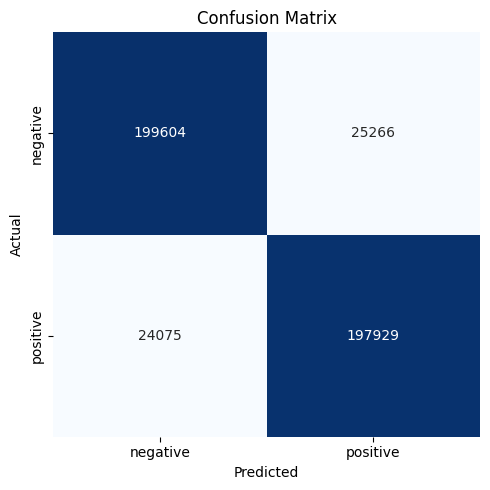

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(5, 5))  # Set the figure size for better visibility
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(),
            fmt='d', cbar=False, cmap='Blues')

# Add axis labels
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")

# Display the heatmap
plt.tight_layout()
plt.show()

# Saving and Deploying the Trained Model

In [21]:
def get_prediction(text):
    """
    Predict the sentiment of a given text using the fine-tuned model.

    Args:
    - text (str): Input text for which sentiment needs to be predicted.

    Returns:
    - int: The predicted sentiment label (e.g., 0 for negative, 1 for positive).
    """
    input_encoded = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():  # Disable gradient calculations for inference to save memory and computation
        outputs = model(**input_encoded)  # Pass the input through the trained model

    logits = outputs.logits  # Extract the raw output scores (logits)
    pred = torch.argmax(logits, dim=1).item()  # Convert logits to the class with the highest score
    return pred

In [22]:
# Save the trained model to the specified directory
trainer.save_model("bert-model")

In [23]:
from transformers import pipeline

# Create a text classification pipeline using the saved model
# The pipeline simplifies the process of making predictions on new data
classifier = pipeline('text-classification', model='bert-model')

Device set to use cuda:0


# Inference on New Test Data

In [24]:
# Load the test.txt file
test_path = 'drive/MyDrive/Colab Notebooks/test_data.txt'

# Parse the test file
# Read each line, split into an ID and text, and apply the cleaning function
test_data = []
with open(test_path, 'r', encoding='utf-8') as file:
    for line in file:
        # Split each line into ID and text based on the first comma
        split_line = line.split(',', 1)
        if len(split_line) == 2:  # Ensure the line contains both an ID and text
            tweet_id, text = split_line  # Extract ID and tweet text
            test_data.append((int(tweet_id), clean_tweet(text.strip())))  # Clean the text

# Convert the parsed test data into a DataFrame
test_df = pd.DataFrame(test_data, columns=['Id', 'text'])

# Apply the prediction function to each tweet in the test DataFrame
test_df['Prediction'] = test_df['text'].apply(get_prediction)

# Replace predictions labeled as 0 (negative sentiment) with -1
test_df['Prediction'] = test_df['Prediction'].replace(0, -1)

# Save the predictions to a CSV file with the specified format
output_path = 'BERT_predictions.csv'
test_df[['Id', 'Prediction']].to_csv(output_path, index=False)